# GLM analysis on the main tasks
It uses nilearn and performs the following steps:

1. Generate group level maps


In [15]:
# Imports
import os
import glob
from nilearn.glm import threshold_stats_img
from nilearn import plotting
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.image import math_img
from nilearn.masking import apply_mask
from mni_to_atlas import AtlasBrowser
atlas = AtlasBrowser("AAL3")

In [2]:
# Settings
#data_dir = '/SCRATCH/users/alexandresayal/BIDS-BRAINPLAYBACK-TASK2/'
data_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/'
space_label = "MNI152NLin2009cAsym"
derivatives_folder = "derivatives/fmriprep23"
task_label = "02a"
smoothing_fwhm = 4.0
high_pass_hz = 0.007
out_dir = os.path.join(data_dir,"derivatives","nilearn_glm")# condition names

In [3]:
condition_names = ['JoyfulActivation', 'Nostalgia', 'Peacefulness', 'Power', 'Sadness', 'Tenderness', 'Tension', 'Transcendence', 'Wonder']

# create strings for contrasts in the format of "condition_name - Noise"
contrasts = []

# add contrast all conditions vs. noise
contrasts.append("Peacefulness + Tenderness + Transcendence + Nostalgia + Power + JoyfulActivation + Tension + Sadness + Wonder - Noise*9")

# iterate to add the other contrasts
for condition in condition_names:
    contrasts.append(condition + " - Noise")

# add more contrasts based on the grouping variables Sublimity, Vitality, and Unease
contrasts.append("Wonder + Transcendence + Tenderness + Nostalgia + Peacefulness - Noise*5") # sublimity
contrasts.append("Power + JoyfulActivation - Noise*2") # vitality
contrasts.append("Tension + Sadness - Noise*2") # unease

# and between the grouping variables
contrasts.append("Wonder*0.2 + Transcendence*0.2 + Tenderness*0.2 + Nostalgia*0.2 + Peacefulness*0.2 - Power*0.5 - JoyfulActivation*0.5") # sublimity vs. vitality
contrasts.append("Power + JoyfulActivation - Tension - Sadness") # vitality vs. unease
contrasts.append("Tension*0.5 + Sadness*0.5 - Wonder*0.2 - Transcendence*0.2 - Tenderness*0.2 - Nostalgia*0.2 - Peacefulness*0.2") # unease vs. sublimity

contrasts_renamed = ['All','JoyfulActivation', 'Nostalgia', 'Peacefulness', 'Power', 'Sadness', 'Tenderness', 'Tension', 'Transcendence', 'Wonder',
                     'Sublimity', 'Vitality', 'Unease', 'SublimityMinusVitality', 'VitalityMinusUnease', 'UneaseMinusSublimity']

['PeacefulnessPlusTendernessPlusTranscendencePlusNostalgiaPlusPowerPlusJoyfulActivationPlusTensionPlusSadnessPlusWonderMinusNoise',
 'JoyfulActivationMinusNoise',
 'NostalgiaMinusNoise',
 'PeacefulnessMinusNoise',
 'PowerMinusNoise',
 'SadnessMinusNoise',
 'TendernessMinusNoise',
 'TensionMinusNoise',
 'TranscendenceMinusNoise',
 'WonderMinusNoise',
 'WonderPlusTranscendencePlusTendernessPlusNostalgiaPlusPeacefulnessMinusNoise',
 'PowerPlusJoyfulActivationMinusNoise',
 'TensionPlusSadnessMinusNoise',
 'WonderPlusTranscendencePlusTendernessPlusNostalgiaPlusPeacefulnessMinusPowerMinusJoyfulActivation',
 'PowerPlusJoyfulActivationMinusTensionMinusSadness',
 'TensionPlusSadnessMinusWonderMinusTranscendenceMinusTendernessMinusNostalgiaMinusPeacefulness']

# 4. Group level analysis

In [4]:
# just some paths again
out_dir_group = os.path.join(data_dir,"derivatives","nilearn_glm","group")
if not os.path.exists(out_dir_group):
    os.makedirs(out_dir_group)

In [48]:
# choose a contrast
c_idx = 10

print(contrasts_renamed[c_idx])

# List all zmap nii.gz files
zmap_files = glob.glob(
    os.path.join(out_dir,
        f"sub-*_task-{task_label}_stat-z_con-{contrasts_renamed[c_idx]}.nii.gz"
    )
)
zmap_files.sort()

subject_list = [os.path.basename(f).split('_')[0] for f in zmap_files]

WonderPlusTranscendencePlusTendernessPlusNostalgiaPlusPeacefulnessMinusNoise


['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09',
 'sub-10',
 'sub-11',
 'sub-12',
 'sub-13']

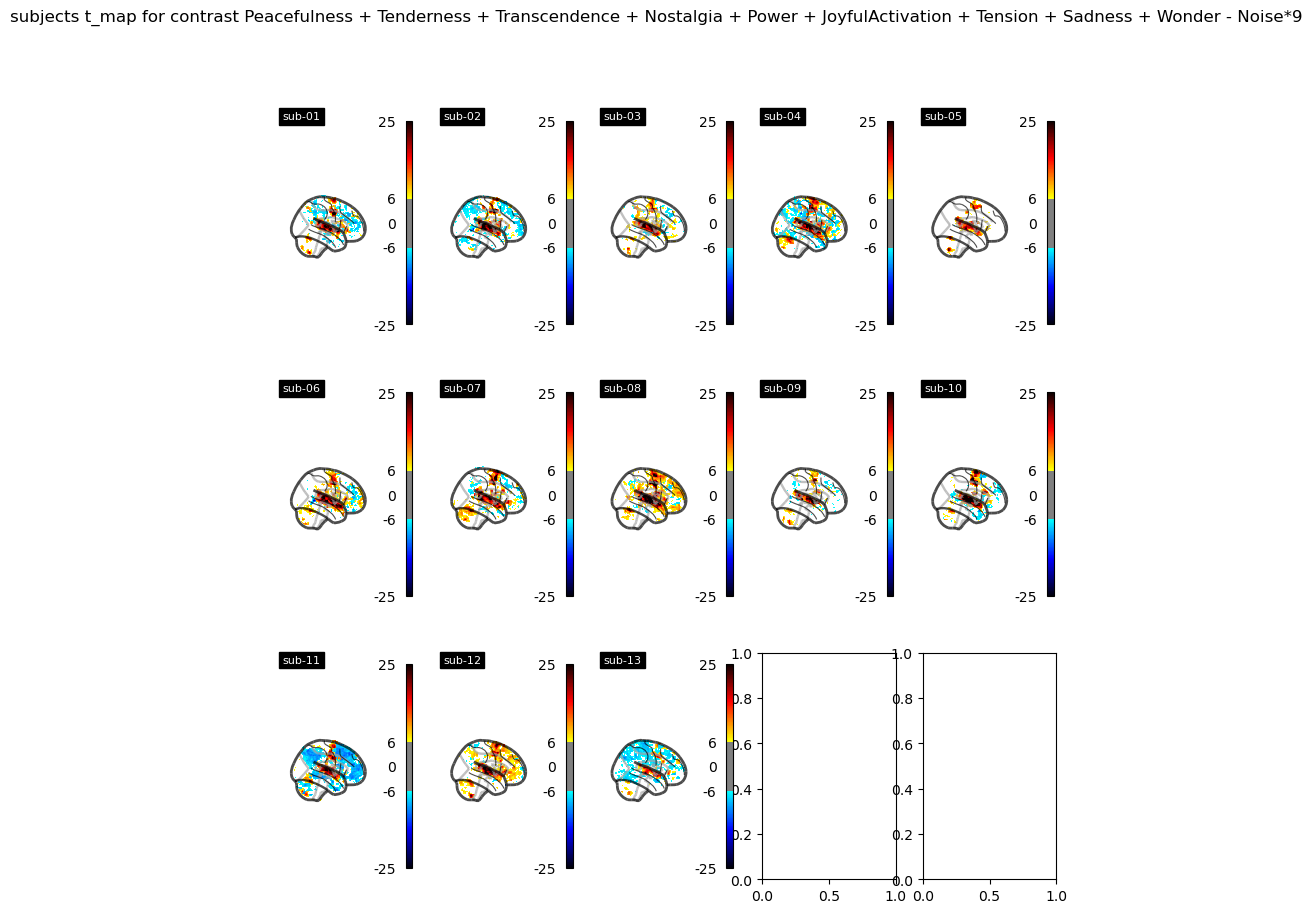

In [6]:
#| label: plot_glass_matrix_singlesubject

# Plot all subjects z_maps for a given contrast
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

for cidx, zmap in enumerate(zmap_files):
    P = plotting.plot_glass_brain(
        zmap,
        colorbar=True,
        threshold=6.0,
        vmax=25,
        axes=axes.flatten()[cidx],
        plot_abs=False,
        display_mode="x",
    )
    P.title(subject_list[cidx], size=8)

fig.suptitle(f"subjects z_map for contrast {contrasts_renamed[c_idx]}")
plt.show()

In [49]:
# create design matrix for 2nd level
second_level_input = zmap_files
design_matrix_g = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["intercept"],
)

# define 2nd level model
second_level_model = SecondLevelModel(smoothing_fwhm=6.0, n_jobs=6)
#second_level_model.minimize_memory = False
second_level_model = second_level_model.fit(
    second_level_input,
    design_matrix=design_matrix_g,
)

# compute contrast (z score map)
z_map_g = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="z_score",
)

# compute contrast (beta map)
beta_map_g = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type='effect_size',
)

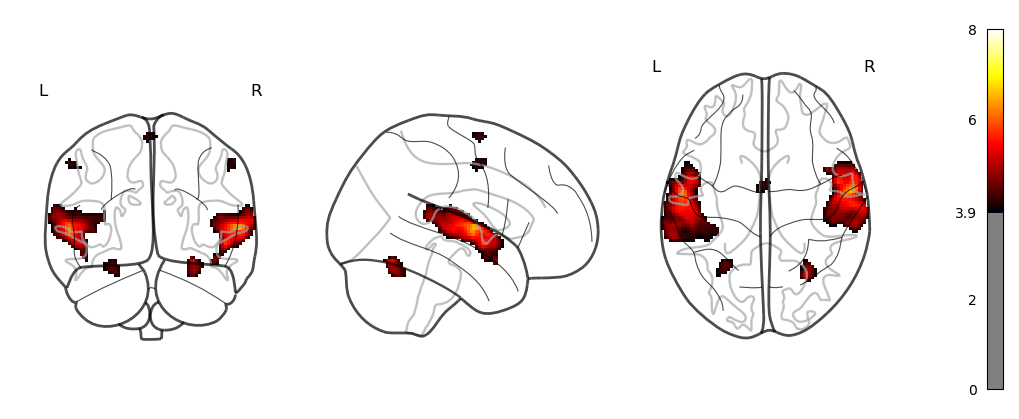

In [50]:
# Threshold zmap and plot it
hc = 'fdr' # None, 'bonferroni', 'fdr'
ct = 25 # cluster threshold
alpha = 0.005 # p-value threshold

clean_map_g, threshold_g = threshold_stats_img(
    z_map_g, alpha=alpha, height_control=hc, cluster_threshold=ct
)

# save group map
z_map_g.to_filename(os.path.join(out_dir_group,
    f"group_task-{task_label}_stat-z_con-_{contrasts_renamed[c_idx]}.nii.gz"
    )
)

# threshold clean_map_g to only show positive values
clean_map_g = math_img("np.maximum(img, 0)", img=clean_map_g)

plotting.plot_glass_brain(
    clean_map_g,
    colorbar=True,
    threshold=threshold_g,
    plot_abs=False,
    display_mode="ortho",
    vmax=8,
    vmin=0,
    figure=plt.figure(figsize=(10, 4)),
    symmetric_cbar=False,
    cmap=nilearn_cmaps["cold_hot"],
)

plt.savefig(os.path.join(out_dir_group,
                         f"group_task-{task_label}_plot-z_con-_{contrasts_renamed[c_idx]}_c-{hc}_p-{alpha}_clusterk-{ct}.png"))

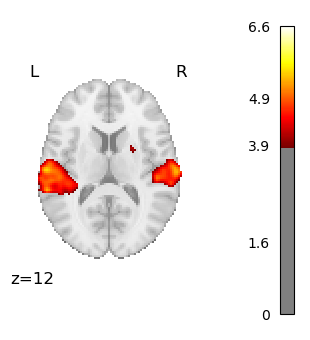

In [9]:
# special plot for poster - at z = 4
plotting.plot_stat_map(
    clean_map_g,
    colorbar=True,
    threshold=threshold_g,
    display_mode="z",
    cmap=nilearn_cmaps["cold_hot"],
    cut_coords=[12]
)


In [16]:
table_g,cluster_map_g = get_clusters_table(z_map_g, threshold_g, ct,
                                return_label_maps=True)

# AAL3 labelling
coordinates = table_g[['X','Y','Z']].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)

# Add the labels to the table
table_g['AAL3'] = aal_labels

# Export cluster table
table_g.to_csv(os.path.join(out_dir_group,
                          f"group_task-{task_label}_table-clusters_con-{contrasts_renamed[c_idx]}_c-{hc}_p-{alpha}_clusterk-{ct}.tsv"),sep='\t')
#print(table)
#print(table.to_latex())
table_g

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,61.5,-4.5,3.5,6.593282,16592,Temporal_Sup_R
1,1a,51.5,1.5,-6.5,6.242368,,Temporal_Pole_Sup_R
2,1b,59.5,5.5,-2.5,6.133268,,Temporal_Pole_Sup_R
3,1c,61.5,-14.5,7.5,5.924558,,Temporal_Sup_R
4,2,-56.5,-6.5,1.5,6.392891,19568,Temporal_Sup_L
5,2a,-58.5,-18.5,5.5,6.313945,,Temporal_Sup_L
6,2b,-50.5,1.5,-4.5,5.694536,,Temporal_Sup_L
7,2c,-62.5,-38.5,11.5,5.344725,,Temporal_Sup_L
8,3,29.5,-62.5,-22.5,5.223292,1320,Cerebellum_6_R
9,4,17.5,-10.5,-16.5,5.043220,304,Hippocampus_R


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



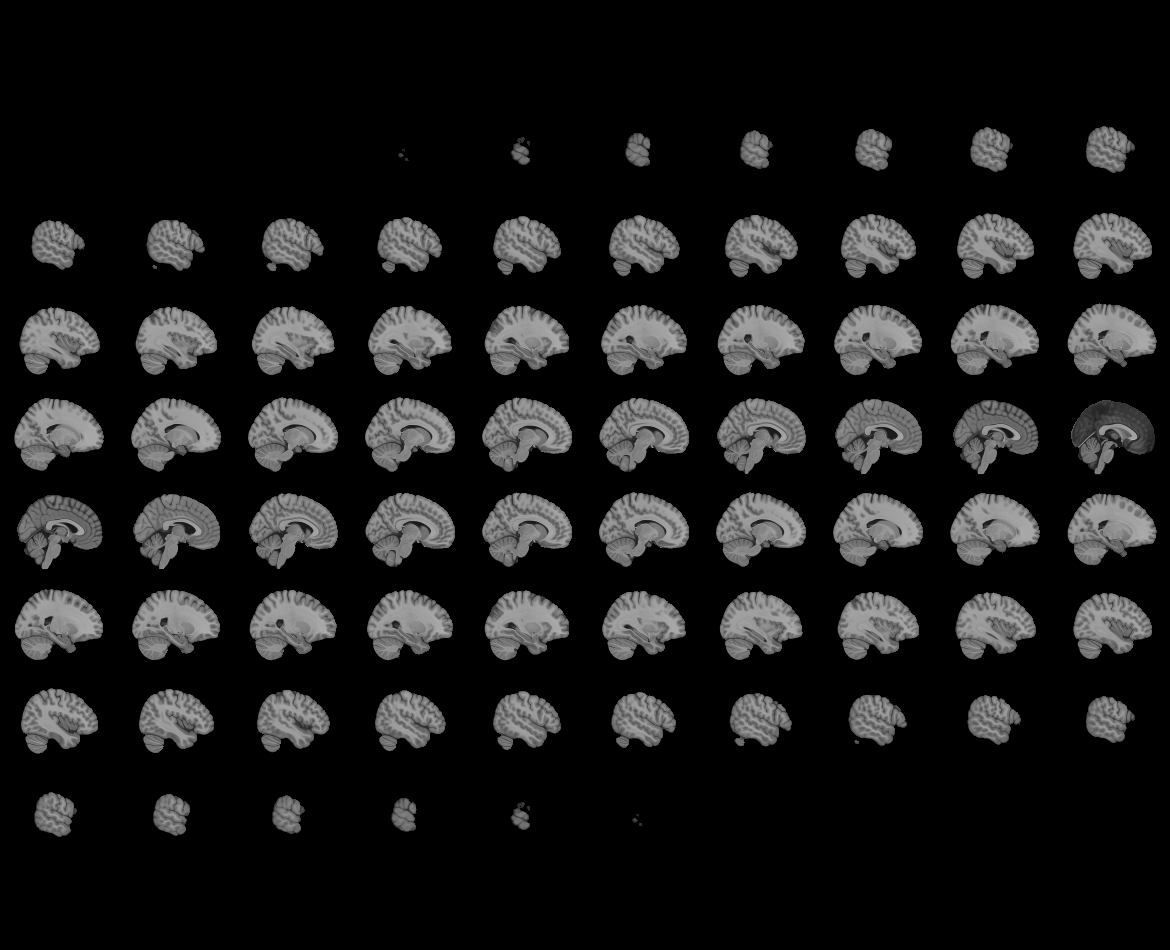
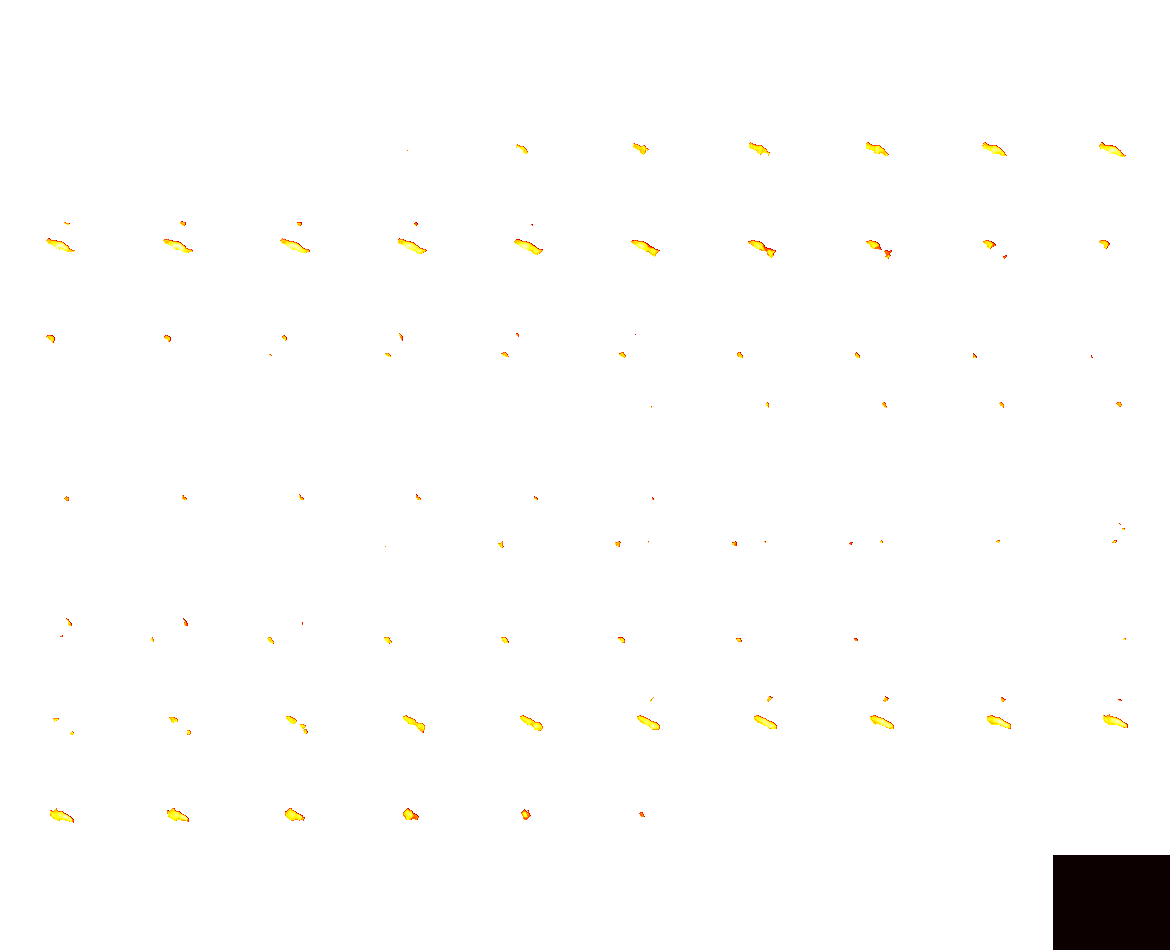

In [11]:
# View map interactively
plotting.view_img(clean_map_g,
         threshold=threshold_g
        )

# ROI analysis

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int32 to float32
  return resample_img(



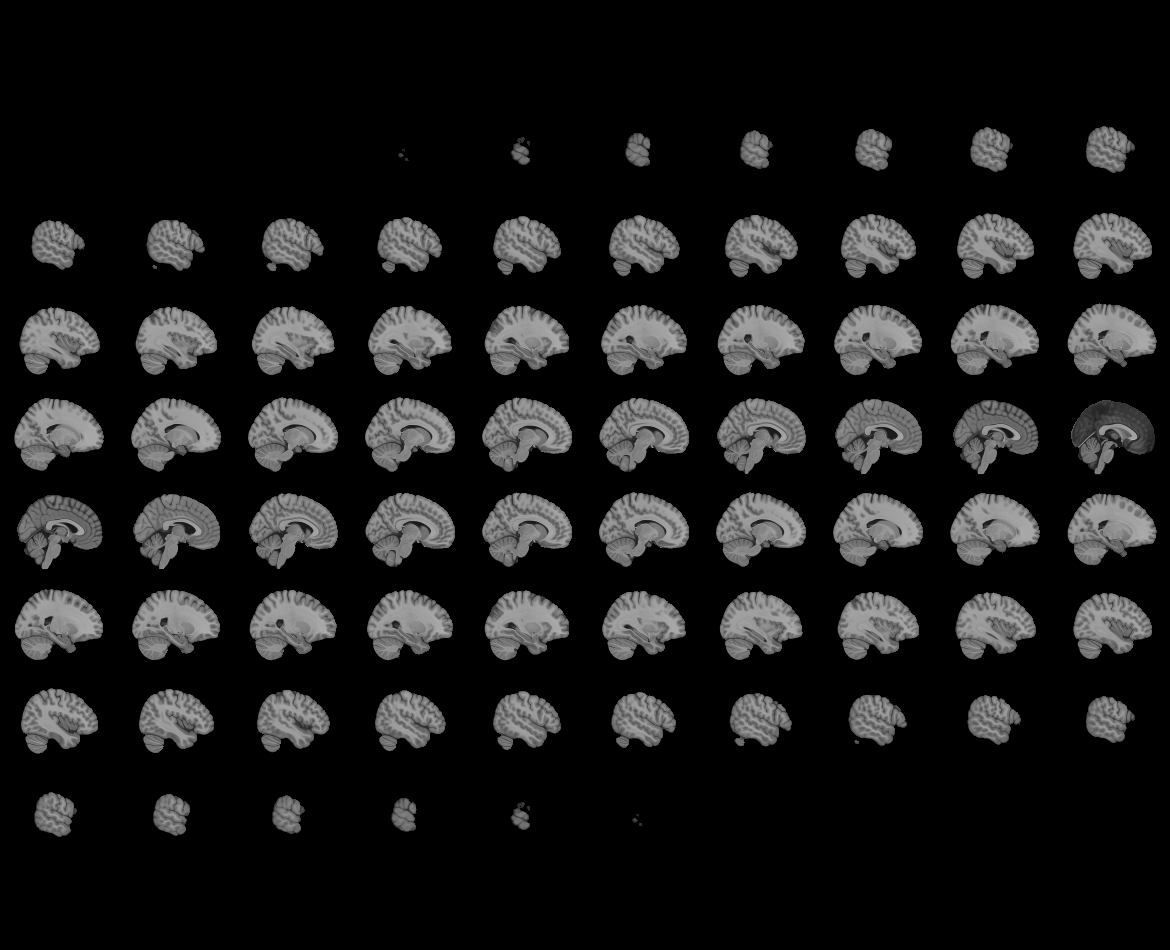
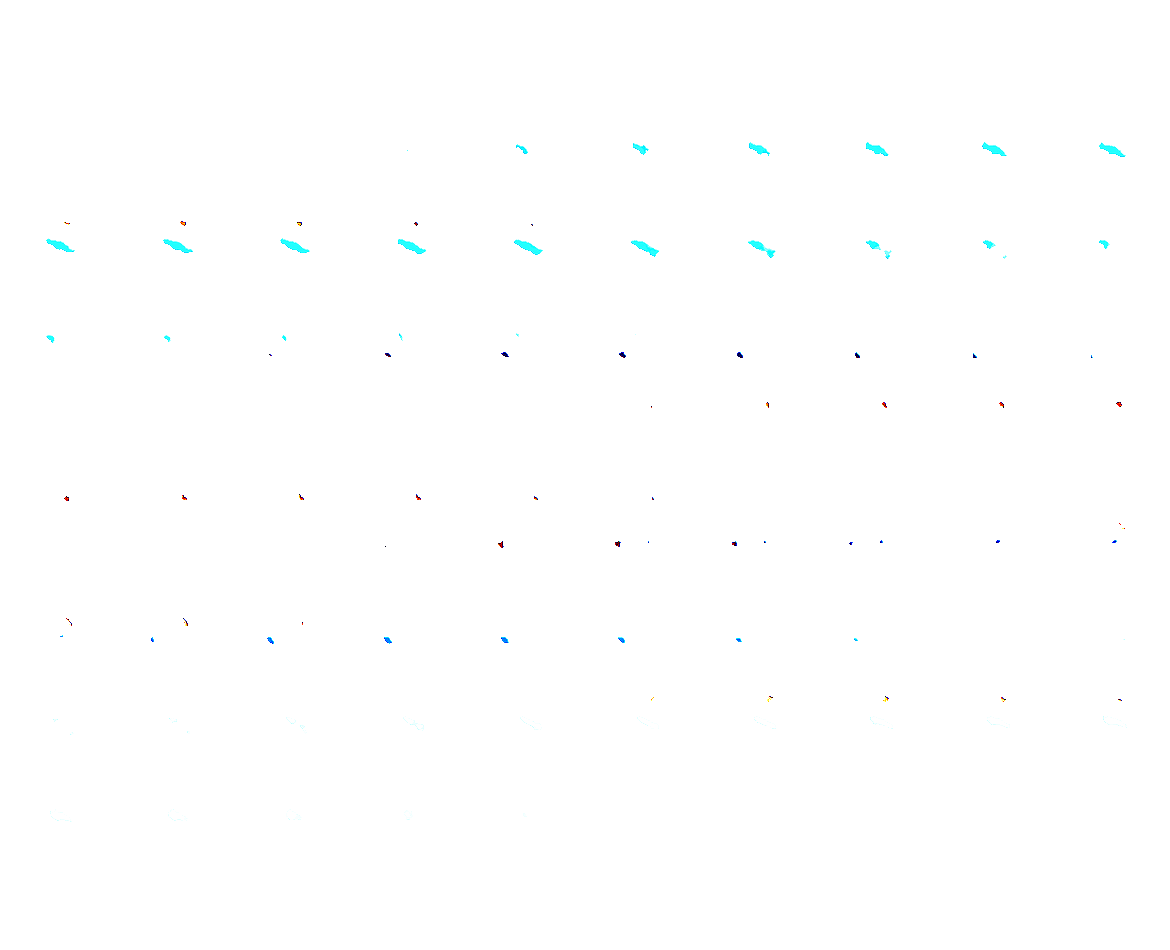

In [12]:
#| label: loc_group_interactive
# Show cluster_map_g
plotting.view_img(cluster_map_g[0],
                  #vmax=3,
                  vmin=1,
                  #resampling_interpolation='nearest',
                  #cmap='hot',
                  symmetric_cmap=False)

In [13]:
# find unique values in cluster_map_g[0]
np.unique(cluster_map_g[0].get_fdata())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

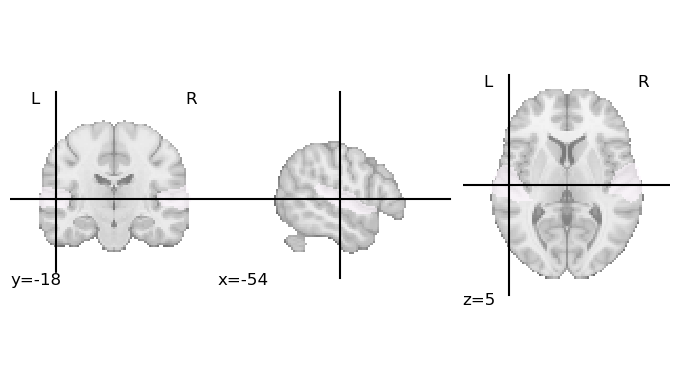

In [19]:
# Generate auditory cluster mask as an example
# in this case, it is values 1 and 2 from cluster_map_g
aux_mask1 = math_img('img == 1', img=cluster_map_g[0])
aux_mask2 = math_img('img == 2', img=cluster_map_g[0])
mask_hMT = math_img('img1 + img2', img1=aux_mask1, img2=aux_mask2)

#plotting.plot_mask(mask_hMT, vmax=1, vmin=0, symmetric_cmap=False)#, cmap='hot')

# plot mask_hMT
plotting.plot_roi(mask_hMT)

# save mask
mask_hMT.to_filename(os.path.join(data_dir,"derivatives","nilearn_glm","group",'mask_a1.nii.gz'))


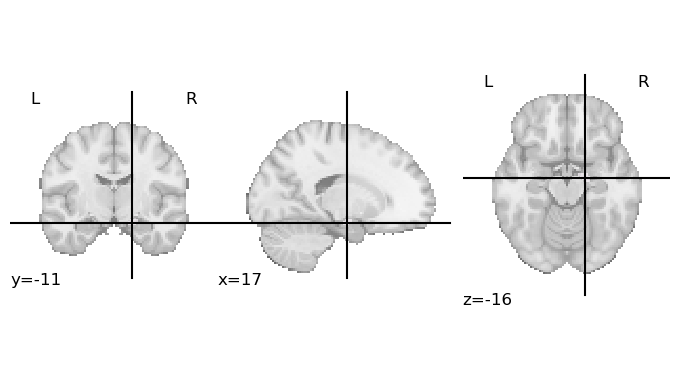

In [18]:
# Generate amygdala cluster mask 
# in this case, it is value 4 from cluster_map_g
aux_mask1 = math_img('img == 4', img=cluster_map_g[0])

#plotting.plot_mask(mask_hMT, vmax=1, vmin=0, symmetric_cmap=False)#, cmap='hot')

# plot mask_hMT
plotting.plot_roi(aux_mask1)

# save mask
aux_mask1.to_filename(os.path.join(data_dir,"derivatives","nilearn_glm","group",'mask_amygdala.nii.gz'))


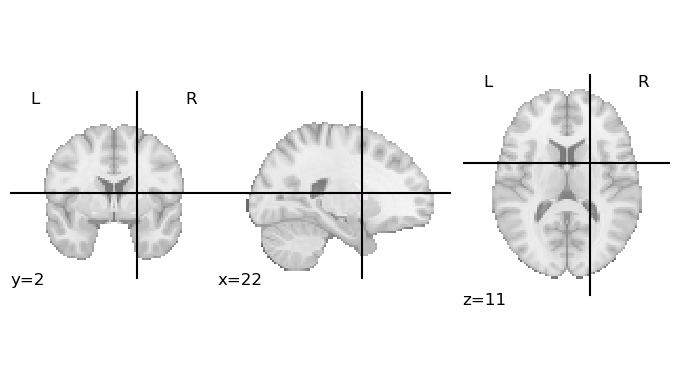

In [20]:
# Generate putamen cluster mask 
# in this case, it is value 10 from cluster_map_g
aux_mask1 = math_img('img == 10', img=cluster_map_g[0])

#plotting.plot_mask(mask_hMT, vmax=1, vmin=0, symmetric_cmap=False)#, cmap='hot')

# plot mask_hMT
plotting.plot_roi(aux_mask1)

# save mask
aux_mask1.to_filename(os.path.join(data_dir,"derivatives","nilearn_glm","group",'mask_putamen.nii.gz'))
